# Scenario Analysis

This Jupyter notebook (Python 3 kernel) assesses GEOCLIM output for the various scenarios explored in this study.

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# additional imports
from tqdm import tqdm_notebook
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Read in Files

In [2]:
# read in the files
path = '/Volumes/GEOCLIM/modern_scenario_outputs/'

ctrl_nc = Dataset(path+'DynSoil_Climate_CTRL_286ppm.nc')
redIA_nc = Dataset(path+'DynSoil_Climate_redIA.nc')
noIA_nc = Dataset(path+'DynSoil_Climate_noIA.nc')
redIAsunda_nc = Dataset(path+'DynSoil_Climate_redIAsunda.nc')
noDeccan_nc = Dataset(path+'DynSoil_Climate_noDeccan.nc')
noET_nc = Dataset(path+'DynSoil_Climate_noET.nc')
noTraps_nc = Dataset(path+'DynSoil_Climate_noTraps.nc')

test_params = pd.read_csv('../Output/test_params.csv')

In [3]:
ctrl_nc.variables.keys()

odict_keys(['lon', 'lat', 'lith', 'runs', 'area', 'atm_CO2_level', 'volcanic_degassing', 'erosion', 'reg_thickness', 'volumetric_weathering', 'weathering', 'x_p_surf'])

In [4]:
test_params.columns

Index(['ke', 'a', 'b', 'krp', 'Ea_rp', 'T0_rp', 'h0', 'kd', 'kw', 'Ea', 'T0',
       'sigma', 'CaMg_1', 'CaMg_2', 'CaMg_3', 'CaMg_4', 'CaMg_5', 'CaMg_6',
       'R2'],
      dtype='object')

In [5]:
compiled_df = test_params.copy()
compiled_df['volcanic_degassing'] = redIA_nc.variables['volcanic_degassing'][:].data

compiled_df['redIA_ppm'] = redIA_nc.variables['atm_CO2_level'][:].data
compiled_df['noIA_ppm'] = noIA_nc.variables['atm_CO2_level'][:].data
compiled_df['redIAsunda_ppm'] = redIAsunda_nc.variables['atm_CO2_level'][:].data
compiled_df['noDeccan_ppm'] = noDeccan_nc.variables['atm_CO2_level'][:].data
compiled_df['noET_ppm'] = noET_nc.variables['atm_CO2_level'][:].data
compiled_df['noTraps_ppm'] = noTraps_nc.variables['atm_CO2_level'][:].data

compiled_df_scenario_list = ['redIA_ppm',
                             'noIA_ppm',
                             'redIAsunda_ppm',
                             'noDeccan_ppm',
                             'noET_ppm',
                             'noTraps_ppm']

## Plots

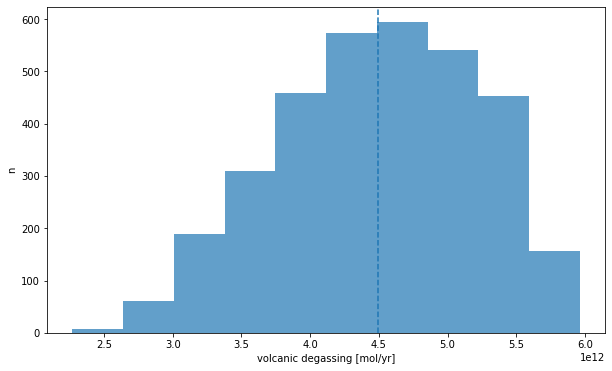

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(compiled_df['volcanic_degassing'], color='C0', alpha=0.7)
ax.axvline(np.mean(compiled_df['volcanic_degassing']), c='C0', ls='--')

ax.set_xlabel('volcanic degassing [mol/yr]')
ax.set_ylabel('n')

plt.show(fig)

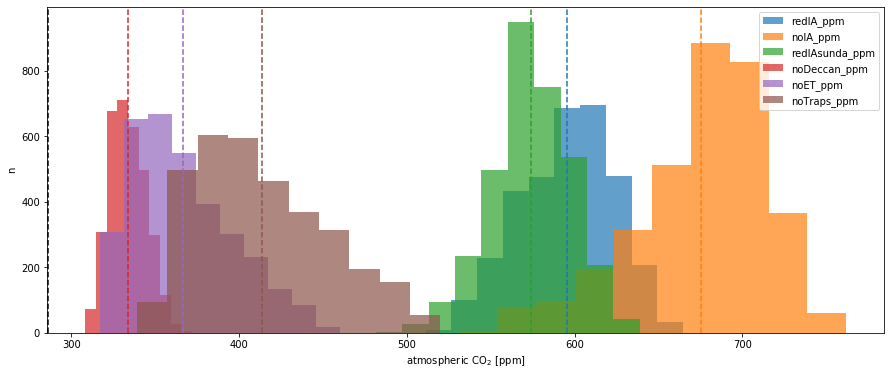

In [7]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(compiled_df_scenario_list)):
    
    ax.hist(compiled_df[compiled_df_scenario_list[i]],
            color='C'+str(i), alpha=0.7, label=compiled_df_scenario_list[i])
    
    ax.axvline(np.mean(compiled_df[compiled_df_scenario_list[i]]), c='C'+str(i), ls='--')

ax.axvline(286, c='k', ls='--')

ax.set_xlabel('atmospheric CO$_{2}$ [ppm]')
ax.set_ylabel('n')
ax.legend()

plt.show(fig)

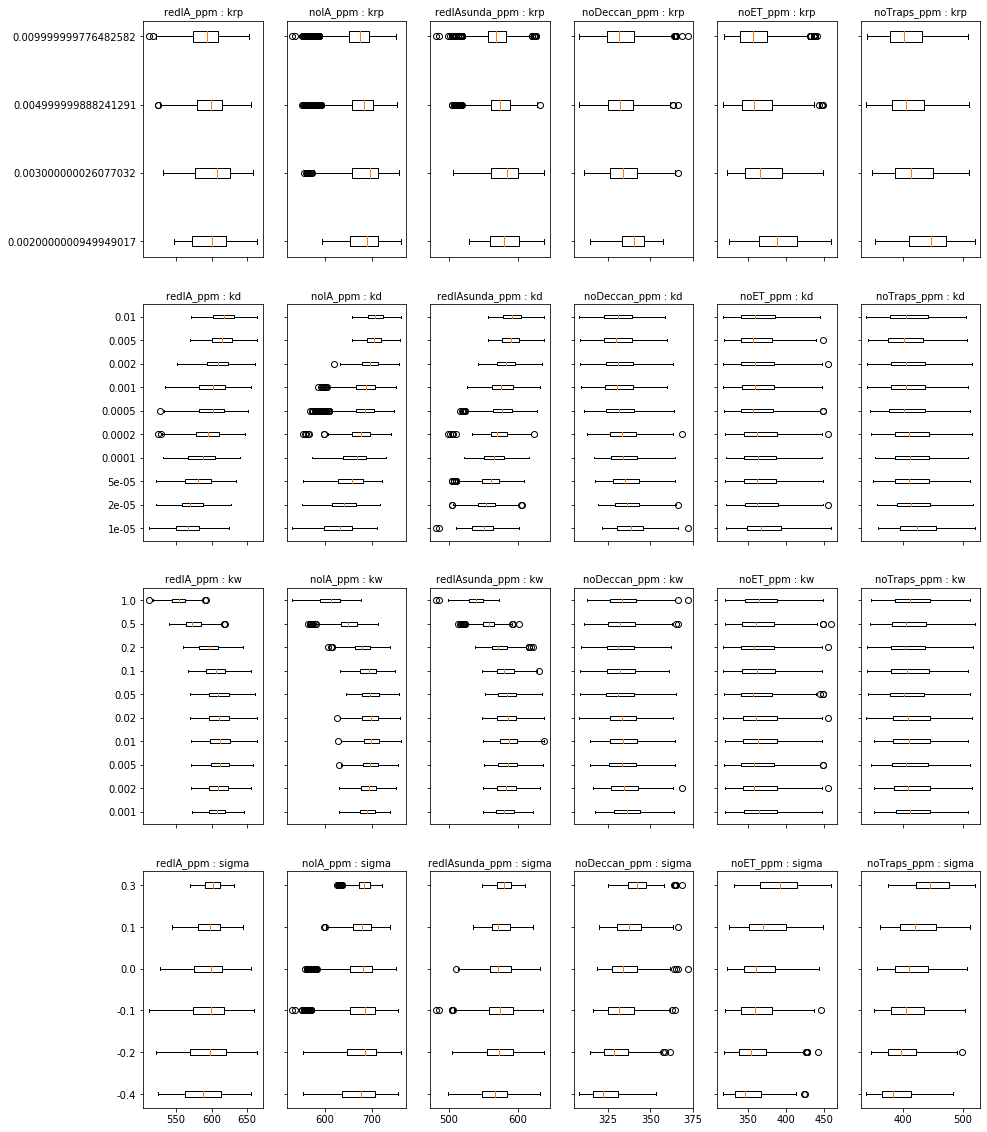

In [8]:
param_cols = ['krp','kd','kw','sigma']

fig, ax = plt.subplots(nrows=len(param_cols), ncols=len(compiled_df_scenario_list),
                       sharex='col', sharey='row', figsize=(15,20))

for i in range(len(param_cols)):
    
    unique_vals = compiled_df[param_cols[i]].unique()
    unique_vals = np.sort(unique_vals)
    
    for j in range(len(compiled_df_scenario_list)):
        
        for k in range(len(unique_vals)):
    
            ax[i][j].boxplot(x=compiled_df[compiled_df[param_cols[i]]==unique_vals[k]][compiled_df_scenario_list[j]],
                             positions=np.arange(k,k+1),
                             vert=False, manage_ticks=False)
        
        ax[i][j].set_title(compiled_df_scenario_list[j] + ' : ' + param_cols[i], fontsize=10)
        
        if j==1:
            
            ax[i][j].set_yticks(np.arange(len(unique_vals)))
            ax[i][j].set_yticklabels(unique_vals)

plt.show(fig)

## PCA

In [9]:
# get a dataframe with just the changing parameters
stat_cols = ['krp','kd','kw','sigma','CaMg_1','CaMg_6','R2','volcanic_degassing']
stat_df = compiled_df[stat_cols].copy()

# standardize
scaler = StandardScaler()
stat_df = scaler.fit_transform(stat_df)
stat_df = pd.DataFrame(data=stat_df, columns=stat_cols)

# PCA
pca = PCA()
PCA_Y = pca.fit_transform(stat_df)

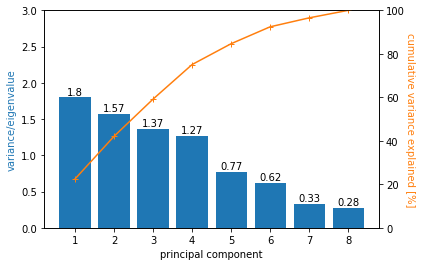

In [10]:
fig, ax = plt.subplots()

rects = ax.bar(np.arange(len(pca.explained_variance_))+1, pca.explained_variance_, color='C0')
ax.set_ylabel('variance/eigenvalue', color='C0')
ax.set_xlabel('principal component')
ax.set_ylim(0,3)

twinax = ax.twinx()
twinax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
            np.cumsum(pca.explained_variance_ratio_)*100, '-+', color='C1')
twinax.set_ylim(0,100)
twinax.set_ylabel('cumulative variance explained [%]', rotation=270, color='C1', labelpad=10)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height>=0:
            ax.text(rect.get_x() + rect.get_width()/2, height+0.08,
                    np.round(height,2),
                    ha='center', va='center')
        else:
            ax.text(rect.get_x() + rect.get_width()/2, height-0.08,
                    np.round(height,2),
                    ha='center', va='center')
            
autolabel(rects)

plt.show(fig)

In [11]:
N = len(stat_cols)
for i in range(N):
    print('PC' + str(i+1) + ': ' + str(np.round(pca.explained_variance_ratio_[i]*100,1)) + '%')

PC1: 22.5%
PC2: 19.6%
PC3: 17.1%
PC4: 15.9%
PC5: 9.6%
PC6: 7.8%
PC7: 4.1%
PC8: 3.4%


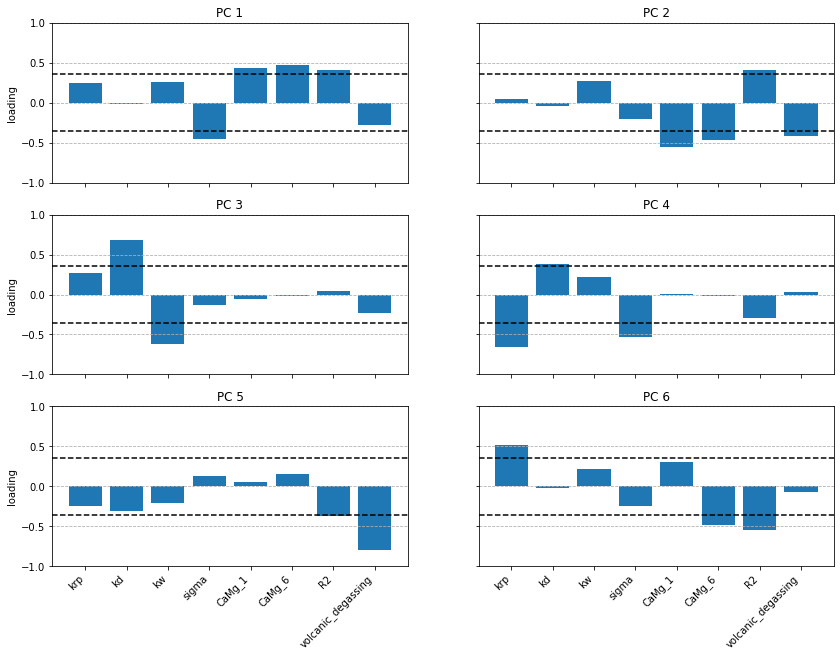

In [12]:
ind = np.arange(N)

component_names = []
for i in range(len(stat_cols)):
    component_names.append('PC ' + str(i+1))

eigenvectors = pd.DataFrame(pca.components_.T, columns=component_names, index=stat_cols)

cutoff = np.sqrt(1/len(stat_cols))

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(14,10), sharey=True, sharex=True)

ax = ax.flatten()

for i in range(6):
    ax[i].bar(ind, eigenvectors['PC ' + str(i+1)], color='C0')
    ax[i].set_ylim(-1,1)
    ax[i].yaxis.grid(ls='--')
    ax[i].axhline(cutoff, ls='--', c='k')
    ax[i].axhline(-cutoff, ls='--', c='k')
    ax[i].set_title('PC ' + str(i+1))
    ax[i].set_xticklabels([])
    
ax[4].set_xticks(ind)
ax[4].set_xticklabels(stat_cols, rotation=45, ha='right')
ax[5].set_xticks(ind)
ax[5].set_xticklabels(stat_cols, rotation=45, ha='right')

ax[0].set_ylabel('loading')
ax[2].set_ylabel('loading')
ax[4].set_ylabel('loading')

plt.show(fig)

## Lithology

The lithology masks and cell areas:

In [13]:
path = '../Output/'

lith_mask_ctrl = Dataset(path+'lith_mask_360_720.nc')
lith_mask_noIA = Dataset(path+'lith_mask_noIA.nc')
lith_mask_redIA = Dataset(path+'lith_mask_redIA.nc')
lith_mask_redIAsunda = Dataset(path+'lith_mask_redIAsunda.nc')

cell_area = Dataset(path+'cell_area_360_720.nc')

In [14]:
lith_mask_ctrl.variables.keys()

odict_keys(['lon', 'lat', 'lith', 'frac'])

In [15]:
cell_area.variables.keys()

odict_keys(['lon', 'lat', 'area'])

The mask that includes all land masses that we consider part of the Indonesia Archipelago:

In [16]:
drive_path = '/Users/yuempark/Documents/Berkeley/Research_GEOCLIM/Paleogeo_GEOCLIM/'

IA_mask_nc = Dataset(drive_path + 'Land_Masks/IA_mask.nc')
IA_mask = IA_mask_nc.variables['Band1'][:,:].data
IA_mask[np.isnan(IA_mask)] = 0
IA_mask[IA_mask > 1e30] = 0

Extract area information about each of the lithologies:

In [17]:
# the number of lithologies, excluding the ocean
n_liths = len(lith_mask_ctrl.variables['lith']) - 1

# extract total lithology area for each scenario
ctrl_lith_area = np.zeros(n_liths)
noIA_lith_area = np.zeros(n_liths)
redIA_lith_area = np.zeros(n_liths)
redIAsunda_lith_area = np.zeros(n_liths)

for i in range(1,n_liths+1):
    ctrl_lith_area[i-1] = np.sum(lith_mask_ctrl.variables['frac'][i,:,:].data * IA_mask *\
                                 cell_area.variables['area'][:,:].data)
    noIA_lith_area[i-1] = np.sum(lith_mask_noIA.variables['frac'][i,:,:].data * IA_mask *\
                                 cell_area.variables['area'][:,:].data)
    redIA_lith_area[i-1] = np.sum(lith_mask_redIA.variables['frac'][i,:,:].data * IA_mask *\
                                  cell_area.variables['area'][:,:].data)
    redIAsunda_lith_area[i-1] = np.sum(lith_mask_redIAsunda.variables['frac'][i,:,:].data * IA_mask *\
                                       cell_area.variables['area'][:,:].data)

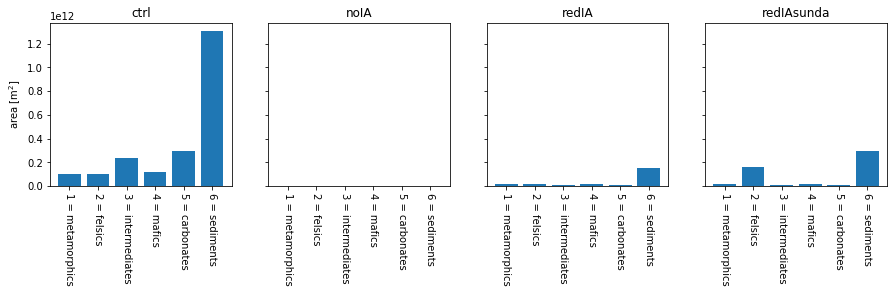

In [18]:
lith_class = ['1 = metamorphics',
              '2 = felsics',
              '3 = intermediates',
              '4 = mafics',
              '5 = carbonates',
              '6 = sediments']

# plot
scenario_lith_area_list = [ctrl_lith_area, noIA_lith_area, redIA_lith_area, redIAsunda_lith_area]
scenario_name_list = ['ctrl', 'noIA', 'redIA', 'redIAsunda']

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(15,3))

x_inds = np.arange(n_liths)

for i in range(4):
    ax[i].bar(x_inds, scenario_lith_area_list[i])
    ax[i].set_xticks(x_inds)
    ax[i].set_xticklabels(lith_class, rotation=270)
    ax[i].set_title(scenario_name_list[i])
    
ax[0].set_ylabel('area [m$^{2}$]')
    
plt.show(fig)

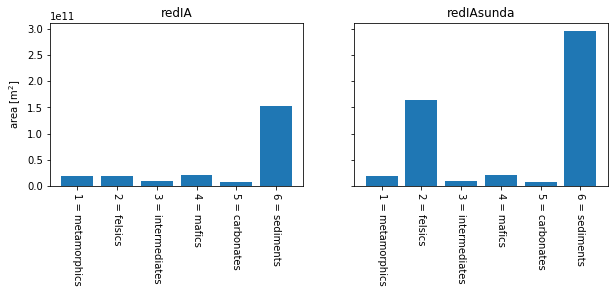

In [19]:
# plot
scenario_lith_area_list_mini = [redIA_lith_area, redIAsunda_lith_area]
scenario_name_list_mini = ['redIA', 'redIAsunda']

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,3))

x_inds = np.arange(n_liths)

for i in range(2):
    ax[i].bar(x_inds, scenario_lith_area_list_mini[i])
    ax[i].set_xticks(x_inds)
    ax[i].set_xticklabels(lith_class, rotation=270)
    ax[i].set_title(scenario_name_list_mini[i])
    
ax[0].set_ylabel('area [m$^{2}$]')
    
plt.show(fig)

Extract CO$_{2}$ consumption information about each of the lithologies:

**IMPORTANT NOTE:** the calculations below are just approximations, since each cell is made up of fractions of lithologies, not single lithologies. Therefore, it is not possible to directly extract the CO$_{2}$ consumption of each lithology.

In [20]:
refresh = False

if refresh:
    
    # extract the weathering map
    ctrl_weathering = ctrl_nc.variables['weathering'][:,:,:].data
    noIA_weathering = noIA_nc.variables['weathering'][:,:,:].data
    redIA_weathering = redIA_nc.variables['weathering'][:,:,:].data
    redIAsunda_weathering = redIAsunda_nc.variables['weathering'][:,:,:].data
    
    # set fill value to 0
    ctrl_weathering[ctrl_weathering > 1e30] = 0
    noIA_weathering[noIA_weathering > 1e30] = 0
    redIA_weathering[redIA_weathering > 1e30] = 0
    redIAsunda_weathering[redIAsunda_weathering > 1e30] = 0
    
    # the number of runs
    n_runs = np.shape(ctrl_nc.variables['weathering'])[0]
    
    # convert from mol/m2/yr to mol/yr
    for j in tqdm_notebook(range(n_runs), desc='sum area', leave=True):
        ctrl_weathering[j,:,:] = ctrl_weathering[j,:,:] * cell_area.variables['area'][:,:].data
        noIA_weathering[j,:,:] = noIA_weathering[j,:,:] * cell_area.variables['area'][:,:].data
        redIA_weathering[j,:,:] = redIA_weathering[j,:,:] * cell_area.variables['area'][:,:].data
        redIAsunda_weathering[j,:,:] = redIAsunda_weathering[j,:,:] * cell_area.variables['area'][:,:].data

    # extract total lithology CO2 consumption for each scenario
    ctrl_lith_CO2 = np.zeros((n_runs, n_liths))
    noIA_lith_CO2 = np.zeros((n_runs, n_liths))
    redIA_lith_CO2 = np.zeros((n_runs, n_liths))
    redIAsunda_lith_CO2 = np.zeros((n_runs, n_liths))

    for i in tqdm_notebook(range(1,n_liths+1), desc='lithology loop', leave=True):
        for j in tqdm_notebook(range(n_runs), desc='run loop', leave=False):
            ctrl_lith_CO2[j,i-1] = np.sum(lith_mask_ctrl.variables['frac'][i,:,:].data * IA_mask *\
                                          ctrl_weathering[j,:,:])
            noIA_lith_CO2[j,i-1] = np.sum(lith_mask_noIA.variables['frac'][i,:,:].data * IA_mask *\
                                          noIA_weathering[j,:,:])
            redIA_lith_CO2[j,i-1] = np.sum(lith_mask_redIA.variables['frac'][i,:,:].data * IA_mask *\
                                           redIA_weathering[j,:,:])
            redIAsunda_lith_CO2[j,i-1] = np.sum(lith_mask_redIAsunda.variables['frac'][i,:,:].data * IA_mask *\
                                                redIAsunda_weathering[j,:,:])
            
    np.savetxt('../Output/ctrl_lith_CO2.csv', ctrl_lith_CO2, delimiter=',')
    np.savetxt('../Output/noIA_lith_CO2.csv', noIA_lith_CO2, delimiter=',')
    np.savetxt('../Output/redIA_lith_CO2.csv', redIA_lith_CO2, delimiter=',')
    np.savetxt('../Output/redIAsunda_lith_CO2.csv', redIAsunda_lith_CO2, delimiter=',')
    
else:
    
    ctrl_lith_CO2 = np.loadtxt('../Output/ctrl_lith_CO2.csv', delimiter=',')
    noIA_lith_CO2 = np.loadtxt('../Output/noIA_lith_CO2.csv', delimiter=',')
    redIA_lith_CO2 = np.loadtxt('../Output/redIA_lith_CO2.csv', delimiter=',')
    redIAsunda_lith_CO2 = np.loadtxt('../Output/redIAsunda_lith_CO2.csv', delimiter=',')

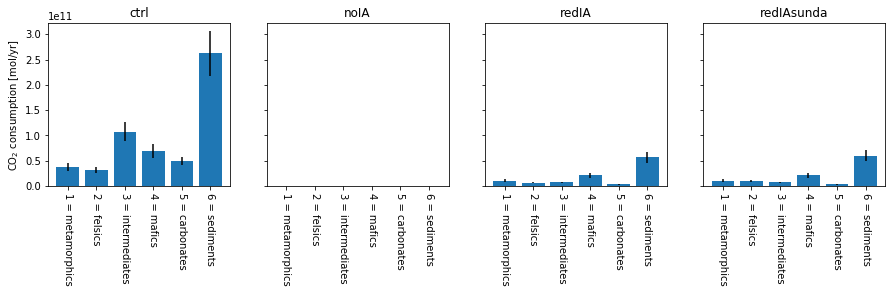

In [21]:
# plot
scenario_lith_CO2_list = [ctrl_lith_CO2, noIA_lith_CO2, redIA_lith_CO2, redIAsunda_lith_CO2]

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(15,3))

x_inds = np.arange(n_liths)

for i in range(4):
    ax[i].bar(x_inds,
              np.mean(scenario_lith_CO2_list[i], axis=0),
              yerr=np.std(scenario_lith_CO2_list[i], axis=0))
    ax[i].set_xticks(x_inds)
    ax[i].set_xticklabels(lith_class, rotation=270)
    ax[i].set_title(scenario_name_list[i])
    
ax[0].set_ylabel('CO$_{2}$ consumption [mol/yr]')
    
plt.show(fig)

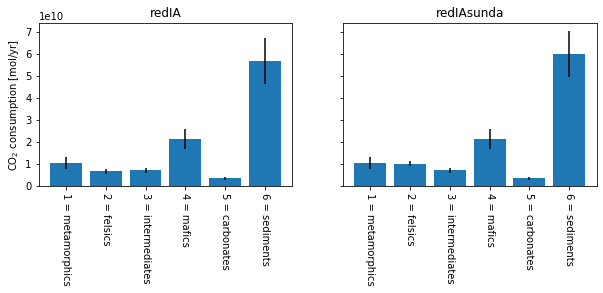

In [22]:
scenario_lith_CO2_list_mini = [redIA_lith_CO2, redIAsunda_lith_CO2]

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,3))

x_inds = np.arange(n_liths)

for i in range(2):
    ax[i].bar(x_inds,
              np.mean(scenario_lith_CO2_list_mini[i], axis=0),
              yerr=np.std(scenario_lith_CO2_list_mini[i], axis=0))
    ax[i].set_xticks(x_inds)
    ax[i].set_xticklabels(lith_class, rotation=270)
    ax[i].set_title(scenario_name_list_mini[i])
    
ax[0].set_ylabel('CO$_{2}$ consumption [mol/yr]')
    
plt.show(fig)

## Box Plot

In [23]:
sns_df_1 = pd.DataFrame({'ppm':redIAsunda_nc.variables['atm_CO2_level'][:].data,
                         'scenario':['redIAsunda']*len(redIAsunda_nc.variables['atm_CO2_level'][:].data)})

sns_df_2 = pd.DataFrame({'ppm':noIA_nc.variables['atm_CO2_level'][:].data,
                         'scenario':['noIA']*len(noIA_nc.variables['atm_CO2_level'][:].data)})

sns_df_3 = pd.DataFrame({'ppm':redIA_nc.variables['atm_CO2_level'][:].data,
                         'scenario':['redIA']*len(redIA_nc.variables['atm_CO2_level'][:].data)})

sns_df_4 = pd.DataFrame({'ppm':noDeccan_nc.variables['atm_CO2_level'][:].data,
                         'scenario':['noDeccan']*len(noDeccan_nc.variables['atm_CO2_level'][:].data)})

sns_df_5 = pd.DataFrame({'ppm':noET_nc.variables['atm_CO2_level'][:].data,
                         'scenario':['noET']*len(noET_nc.variables['atm_CO2_level'][:].data)})

sns_df_6 = pd.DataFrame({'ppm':noTraps_nc.variables['atm_CO2_level'][:].data,
                         'scenario':['noTraps']*len(noTraps_nc.variables['atm_CO2_level'][:].data)})

sns_df = pd.concat([sns_df_1,sns_df_2,sns_df_3,sns_df_4,sns_df_5,sns_df_6], ignore_index=True)

In [24]:
sns_df_scenario_list = ['noIA',
                        'redIA',
                        'redIAsunda',
                        'noDeccan',
                        'noET',
                        'noTraps']

for i in range(len(sns_df_scenario_list)):
    sns_df_slice = sns_df[sns_df['scenario']==sns_df_scenario_list[i]]
    print(sns_df_scenario_list[i])
    print('      mean = {:.1f}'.format(np.mean(sns_df_slice['ppm'])))
    print('    2sigma = {:.1f}'.format(2*np.std(sns_df_slice['ppm'])))
    print('       min = {:.1f}'.format(np.min(sns_df_slice['ppm'])))
    print('       max = {:.1f}'.format(np.max(sns_df_slice['ppm'])))
    print('        5% = {:.1f}'.format(np.percentile(sns_df_slice['ppm'], 5)))
    print('       95% = {:.1f}'.format(np.percentile(sns_df_slice['ppm'], 95)))
    print('')

noIA
      mean = 675.4
    2sigma = 78.7
       min = 531.0
       max = 761.9
        5% = 597.8
       95% = 729.2

redIA
      mean = 595.5
    2sigma = 55.0
       min = 511.3
       max = 664.8
        5% = 547.1
       95% = 638.1

redIAsunda
      mean = 573.9
    2sigma = 47.3
       min = 481.4
       max = 639.0
        5% = 532.7
       95% = 611.0

noDeccan
      mean = 333.6
    2sigma = 21.6
       min = 308.2
       max = 372.0
        5% = 317.5
       95% = 352.1

noET
      mean = 366.5
    2sigma = 59.6
       min = 316.9
       max = 460.4
        5% = 327.5
       95% = 424.0

noTraps
      mean = 413.9
    2sigma = 77.8
       min = 339.2
       max = 520.0
        5% = 359.9
       95% = 488.0



In [25]:
pCO2_alkenones = pd.read_csv('../Input/pCO2/Foster2017a_alkenones.csv')
pCO2_boron = pd.read_csv('../Input/pCO2/Foster2017a_boron.csv')
pCO2_liverworts = pd.read_csv('../Input/pCO2/Foster2017a_liverworts.csv')
pCO2_paleosols = pd.read_csv('../Input/pCO2/Foster2017a_paleosols.csv')
pCO2_stomat = pd.read_csv('../Input/pCO2/Foster2017a_stomat.csv')

pCO2_all = pd.concat([pCO2_alkenones,pCO2_boron,pCO2_liverworts,pCO2_paleosols,pCO2_stomat], ignore_index=True)

pCO2_LOESS = pd.read_csv('../Input/pCO2/Foster2017a_LOESS.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


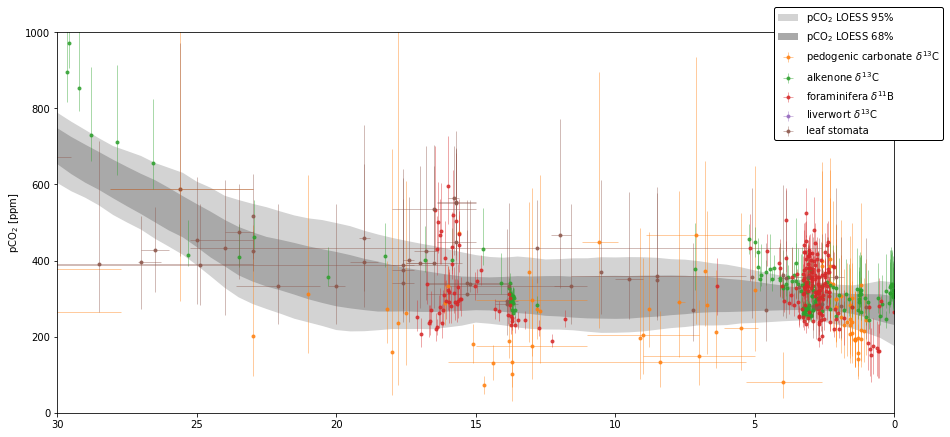

In [26]:
fig, ax = plt.subplots(figsize=(15,7))

h1 = ax.fill_between(x=pCO2_LOESS['Age (Ma)'],y1=pCO2_LOESS['lw95%'],y2=pCO2_LOESS['up95%'],
                     facecolor='lightgrey', zorder=1, label='pCO$_{2}$ LOESS 95%')
h2 = ax.fill_between(x=pCO2_LOESS['Age (Ma)'],y1=pCO2_LOESS['lw68%'],y2=pCO2_LOESS['up68%'],
                     facecolor='darkgrey', zorder=2, label='pCO$_{2}$ LOESS 68%')

h3 = ax.errorbar(pCO2_paleosols['Age_Ma'], pCO2_paleosols['CO2_ppm'],
                 xerr=[pCO2_paleosols['Age_Ma']-pCO2_paleosols['Age_young'], pCO2_paleosols['Age_old']-pCO2_paleosols['Age_Ma']],
                 yerr=[pCO2_paleosols['CO2_ppm']-pCO2_paleosols['CO2_low'], pCO2_paleosols['CO2_high']-pCO2_paleosols['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C1', marker='o', markersize=3,
                 label='pedogenic carbonate $\delta^{13}$C')
h4 = ax.errorbar(pCO2_alkenones['Age_Ma'], pCO2_alkenones['CO2_ppm'],
                 xerr=[pCO2_alkenones['Age_Ma']-pCO2_alkenones['Age_young'], pCO2_alkenones['Age_old']-pCO2_alkenones['Age_Ma']],
                 yerr=[pCO2_alkenones['CO2_ppm']-pCO2_alkenones['CO2_low'], pCO2_alkenones['CO2_high']-pCO2_alkenones['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C2', marker='o', markersize=3,
                 label='alkenone $\delta^{13}$C')
h5 = ax.errorbar(pCO2_boron['Age_Ma'], pCO2_boron['CO2_ppm'],
                 xerr=[pCO2_boron['Age_Ma']-pCO2_boron['Age_young'], pCO2_boron['Age_old']-pCO2_boron['Age_Ma']],
                 yerr=[pCO2_boron['CO2_ppm']-pCO2_boron['CO2_low'], pCO2_boron['CO2_high']-pCO2_boron['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C3', marker='o', markersize=3,
                 label='foraminifera $\delta^{11}$B')
h6 = ax.errorbar(pCO2_liverworts['Age_Ma'], pCO2_liverworts['CO2_ppm'],
                 xerr=[pCO2_liverworts['Age_Ma']-pCO2_liverworts['Age_young'], pCO2_liverworts['Age_old']-pCO2_liverworts['Age_Ma']],
                 yerr=[pCO2_liverworts['CO2_ppm']-pCO2_liverworts['CO2_low'], pCO2_liverworts['CO2_high']-pCO2_liverworts['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C4', marker='o', markersize=3,
                 label='liverwort $\delta^{13}$C')
h7 = ax.errorbar(pCO2_stomat['Age_Ma'], pCO2_stomat['CO2_ppm'],
                 xerr=[pCO2_stomat['Age_Ma']-pCO2_stomat['Age_young'], pCO2_stomat['Age_old']-pCO2_stomat['Age_Ma']],
                 yerr=[pCO2_stomat['CO2_ppm']-pCO2_stomat['CO2_low'], pCO2_stomat['CO2_high']-pCO2_stomat['CO2_ppm']],
                 linestyle='none', elinewidth=0.5, alpha=0.8, c='C5', marker='o', markersize=3,
                 label='leaf stomata')

ax.set_xlim(30,0)

ax.set_ylim(0,1000)
ax.set_ylabel('pCO$_{2}$ [ppm]')

ax.legend(handles=[h1,h2,h3,h4,h5,h6,h7],
          edgecolor='k',facecolor='white',loc='upper left',bbox_to_anchor=(0.85,1.08),framealpha=1)

plt.show(fig)

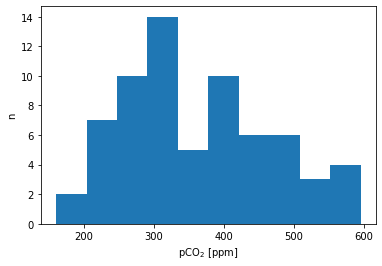

In [27]:
fig, ax = plt.subplots()

ax.hist(pCO2_all[(pCO2_all['Age_Ma']>15)&(pCO2_all['Age_Ma']<20)]['CO2_ppm'])

ax.set_xlabel('pCO$_{2}$ [ppm]')
ax.set_ylabel('n')

plt.show(fig)

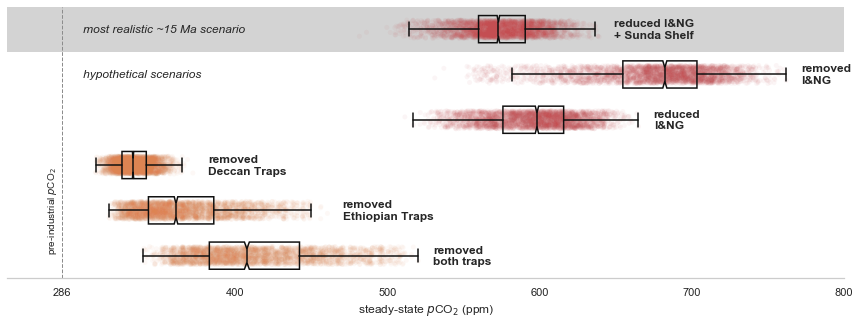

In [28]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(15,5))

sns.stripplot(x='ppm', y='scenario', data=sns_df, palette=['C3','C3','C3','C1','C1','C1'],
              dodge=True, jitter=0.2, alpha=0.05, zorder=-99)

sns.boxplot(x='ppm', y='scenario', data=sns_df, color='k', fliersize=0, width=0.6, notch=True, zorder=99)

for patch in ax.artists:
    r,g,b,a = patch.get_facecolor()
    patch.set_facecolor((0,0,0,0))
    
ax.axvline(286, c='C7', lw=1, ls='--')
ax.text(284, 4, 'pre-industrial $\it{p}$CO$_{2}$', fontsize=10,
        horizontalalignment='right', verticalalignment='center', rotation=90)

#ax.axhline(0.5, c='k', ls='--')
ax.text(300, 0, 'most realistic ~15 Ma scenario', fontsize=12, style='italic',
        horizontalalignment='left', verticalalignment='center')
ax.text(300, 1, 'hypothetical scenarios', fontsize=12, style='italic',
        horizontalalignment='left', verticalalignment='center')

fontsize = 12
ax.text(np.max(redIAsunda_nc.variables['atm_CO2_level'][:].data)+10, 0,
        'reduced I&NG\n+ Sunda Shelf', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(noIA_nc.variables['atm_CO2_level'][:].data)+10, 1,
        'removed\nI&NG', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(redIA_nc.variables['atm_CO2_level'][:].data)+10, 2,
        'reduced\nI&NG', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

fontsize = 12
ax.text(np.max(noDeccan_nc.variables['atm_CO2_level'][:].data)+10, 3,
        'removed\nDeccan Traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(noET_nc.variables['atm_CO2_level'][:].data)+10, 4,
        'removed\nEthiopian Traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')
ax.text(np.max(noTraps_nc.variables['atm_CO2_level'][:].data)+10, 5,
        'removed\nboth traps', fontweight='bold', fontsize=fontsize,
        horizontalalignment='left', verticalalignment='center')

ax.set_yticklabels([])
ax.set_ylabel('')
ax.set_xlabel('steady-state $\it{p}$CO$_{2}$ (ppm)')

ax.set_xlim(250,800)
ax.set_xticks([286,400,500,600,700,800])

rect = patches.Rectangle((250,-0.5),550,1,
                         edgecolor='none',facecolor='lightgrey',zorder=-999)
ax.add_patch(rect)

ax.xaxis.grid(False)
sns.despine(left=True)

fig.savefig('../../Manuscript/Figures/scenario_pCO2.pdf',bbox_inches='tight')

plt.show(fig)